Autor: Pablo Manresa Nebot  
Ejemplo de procesamiento de datasets con learn2learn 

# Se descarga el paquete de learn2learn

In [ ]:
!pip install learn2learn

     |████████████████████████████████| 841 kB 6.9 MB/s 
     |████████████████████████████████| 2.9 MB 33.6 MB/s 
     |████████████████████████████████| 135 kB 47.6 MB/s 
     |████████████████████████████████| 96 kB 3.4 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 156 kB 44.0 MB/s 
     |████████████████████████████████| 1.4 MB 38.1 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
     |████████████████████████████████| 144 kB 39.4 MB/s 
     |████████████████████████████████| 94 kB 4.3 MB/s 
     |████████████████████████████████| 271 kB 59.4 MB/s 
     |████████████████████████████████| 4.0 MB 33.0 MB/s 
  Created wheel for learn2learn: filename=learn2learn-0.1.7-cp37-cp37m-linux_x86_64.whl size=938524 sha256=ead6ea9b2fcd53bc3f69f455ec8c60e62a0f41cc9fb43762c372dcc2d10f6338
  Stored in directory: /root/.cache/pip/wheels/66/29/ac/1d46fdb88fb1fb02491123ef3fcec13d5363eb14fec6f8af05
  Created wheel for qpth: filena

Se cargan las librerías necesarias

In [ ]:
import learn2learn as l2l
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Apertura y manejo de datasets

Se definen las transformaciones

In [ ]:
transformations = torchvision.transforms.Compose([
                          torchvision.transforms.Resize(28, interpolation= torchvision.transforms.InterpolationMode.BILINEAR),
                          torchvision.transforms.ToTensor(),
                          lambda x: x/255.,
                      ])

Se puede descargar el dataset directamente de **learn2learn** directamente mediante:

In [ ]:
omniglot = l2l.vision.datasets.FullOmniglot(root='./data',
                                            transform=transformations,
                                            download=True)

omniglot

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


O bien, mediante Pytorch:

In [ ]:
n_ways = 5
k_shot = 5

In [ ]:
dataset_torch = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=transformations
)

# Se ppasa a formato `MetaDataset`
meta_omniglot = l2l.data.MetaDataset(dataset_torch)

# Se crean las transformaciones
transforms = [
    l2l.data.transforms.NWays(meta_omniglot, n=n_ways),
    l2l.data.transforms.KShots(meta_omniglot, k=k_shot),
    l2l.data.transforms.LoadData(meta_omniglot),
]

# Se crean las tareas 
taskset = l2l.data.TaskDataset(meta_omniglot, transforms, num_tasks=100)
(X_t, y_t) = next(iter(taskset))

Files already downloaded and verified


Cada tarea tiene una dimensiones de:

In [ ]:
X_t.shape, y_t.shape

(torch.Size([25, 1, 28, 28]), torch.Size([25]))

In [ ]:
y_t

tensor([246, 246, 246, 246, 246, 600, 600, 600, 600, 600, 695, 695, 695, 695,
        695, 298, 298, 298, 298, 298, 642, 642, 642, 642, 642])

Se pueden filtrar para que no aparezcan las muestras cuya clase es la 841, por ejemplo:

In [ ]:
data = l2l.data.FilteredMetaDataset(dataset_torch, [841, 708, 426, 272])
assert torch.equal(torch.Tensor(data.labels), torch.Tensor([841, 708, 426, 272])), "Filtrado incorrecto"
data.labels

[841, 708, 426, 272]

Como puede observarse, tras el filtrado únicamente se tienen datos pertenecientes a esas clases.

Uniendo los anteriores aspectos, se podría cargar y generar el dataset en formato Few-shot de forma eficiente ppara el caso de Cifar-FS, de la siguiente manera:

In [ ]:
part_entrenamiento = torchvision.datasets.CIFAR100(download=True, train=True, root="./cifar", 
                                                   transform = torchvision.transforms.Compose([
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        
                                                   ]))

part_entrenamiento = l2l.data.MetaDataset(part_entrenamiento)

nways = 10
kshots = 10

transformaciones = [
                    # Se dividen los datos de entrenamiento en n clases con k instancias cada una.
                    l2l.data.transforms.FusedNWaysKShots(part_entrenamiento, n=nways, k=kshots),
                    # Se cargan los datos en base a los ajustes anteriores
                    l2l.data.transforms.LoadData(part_entrenamiento),
                    # Se remapean las etiquetas de 0 a len(unique(train_dataset.labels))
                    l2l.data.transforms.RemapLabels(part_entrenamiento),
                    # Se ordenan las instancias en función de su clase de forma que vaya de 0 a len(unique(train_dataset.labels))
                    l2l.data.transforms.ConsecutiveLabels(part_entrenamiento),
]

tareas_entrenamiento =  l2l.data.TaskDataset(part_entrenamiento, num_tasks=1000, task_transforms=transformaciones)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar/cifar-100-python.tar.gz to ./cifar


In [ ]:
def imshow(img, title = ""):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Se obtiene una muestra:

In [ ]:
(imagenes, etiquetas) = tareas_entrenamiento.sample()

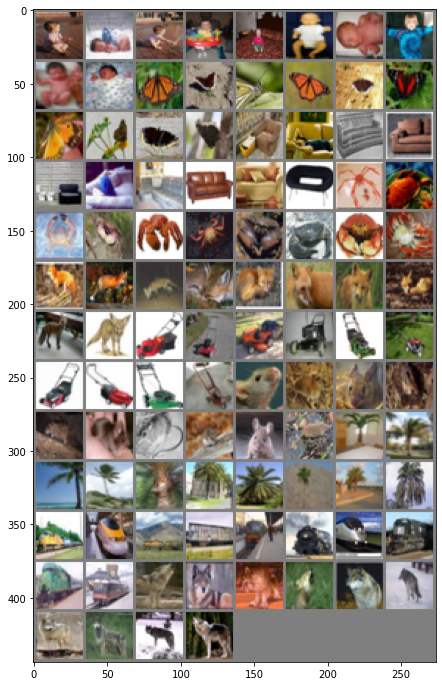

In [ ]:
plt.figure(figsize=(12, 12))
grid = torchvision.utils.make_grid(imagenes)
imshow(grid)

In [ ]:
etiquetas

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6])

Como es posible observar, a partir del dataset Cifar-100 de Pytorch, se ha creado un dataset en formato few-shot learning con 10 clases y 10 insttancias para cada clase y con 1000 tareas.  
  
  El motivo por el cual las clases van del 0 al 9, es porque se ha usado la función `l2l.data.transforms.ConsecutiveLabels(part_entrenamiento)`.

# Unión de datasets.  
  
      
      

Es posible unir dos datasets con la intención de crear tareas de Few-shot learning más complejas, y crear un modelo robusto que sea capaz de resolver dichos problemas. Por ejemplo, usando el dataset Cifar-100:

In [ ]:
transformaciones = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((112, 112)),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        
                                            ])

cars = torchvision.datasets.StanfordCars(root="./stanford_cars", split="train", download=True, transform=transformaciones)

  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting stanford_cars/stanford_cars/car_devkit.tgz to stanford_cars/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting stanford_cars/stanford_cars/cars_train.tgz to stanford_cars/stanford_cars


dataset `OxfordIIITPet`

In [ ]:
pets = torchvision.datasets.OxfordIIITPet(root="./pets", split="trainval", download=True, transform=transformaciones)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting pets/oxford-iiit-pet/images.tar.gz to pets/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting pets/oxford-iiit-pet/annotations.tar.gz to pets/oxford-iiit-pet


In [ ]:
cars_meta = l2l.data.MetaDataset(cars)
pets_meta = l2l.data.MetaDataset(pets)

cars_and_meta = l2l.data.UnionMetaDataset([cars_meta, pets_meta])

In [ ]:
assert( (len(cars_meta.labels) + len(pets_meta.labels)) == len(cars_and_meta.labels)), "Unión incorrecta"

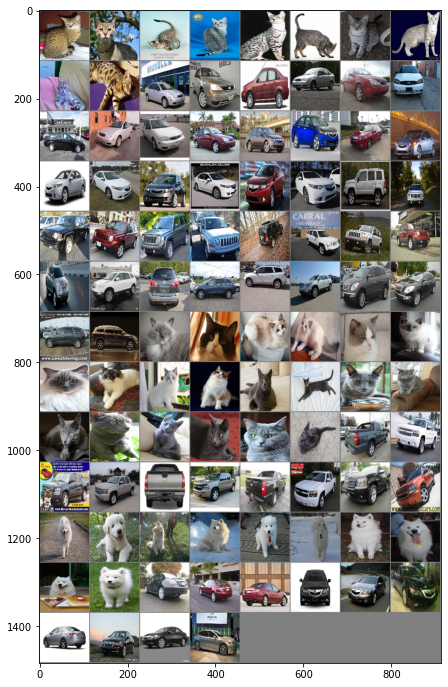

In [ ]:
transforms = [
    l2l.data.transforms.NWays(cars_and_meta, n=10),
    l2l.data.transforms.KShots(cars_and_meta, k=10),
    l2l.data.transforms.LoadData(cars_and_meta),
]
taskset = l2l.data.TaskDataset(cars_and_meta, transforms, num_tasks=1000)

(imagenes, etiquetas) = taskset.sample()

plt.figure(figsize=(12, 12))
grid = torchvision.utils.make_grid(imagenes)
imshow(grid)

Se dividen los datos en conjuntos de soporte y query mediante la función `partition_task`

tensor([  8,   8,   8,   8,   8,   8,   8,  59,  59,  59,  59,  59,  59,  59,
         68,  68,  68,  68,  68,  68,  68,  74,  74,  74,  74,  74,  74,  74,
        127, 127, 127, 127, 127, 127, 127, 140, 140, 140, 140, 140, 140, 140,
        179, 179, 179, 179, 179, 179, 179, 180, 180, 180, 180, 180, 180, 180,
        202, 202, 202, 202, 202, 202, 202, 204, 204, 204, 204, 204, 204, 204])


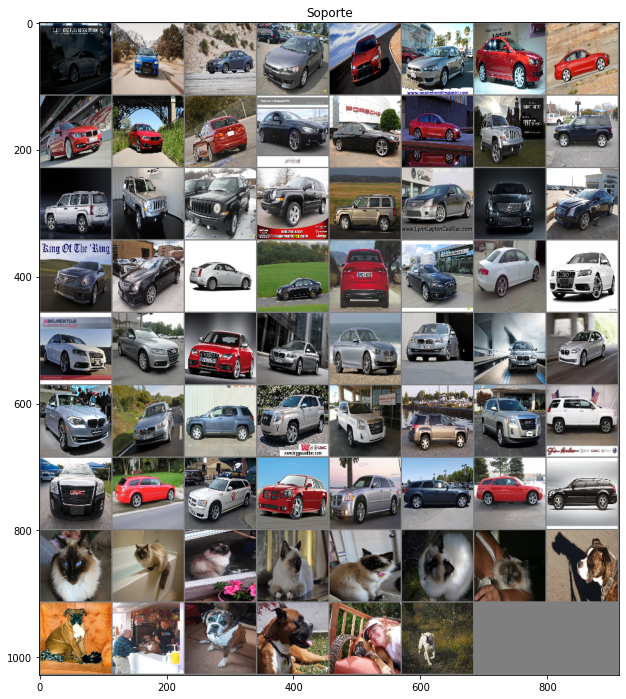

In [ ]:
plt.figure(figsize=(12, 12))

imgs, clases = next(taskset)

# Soporte = 7 imágenes por clase, query = 3.
(img_soporte, clases_soporte), (img_query, clases_query) = l2l.data.partition_task(imgs, clases, shots=7)

print(clases_soporte)
grid = torchvision.utils.make_grid(img_soporte)
imshow(grid, "Soporte")

Query:

tensor([  8,   8,   8,  59,  59,  59,  68,  68,  68,  74,  74,  74, 127, 127,
        127, 140, 140, 140, 179, 179, 179, 180, 180, 180, 202, 202, 202, 204,
        204, 204])


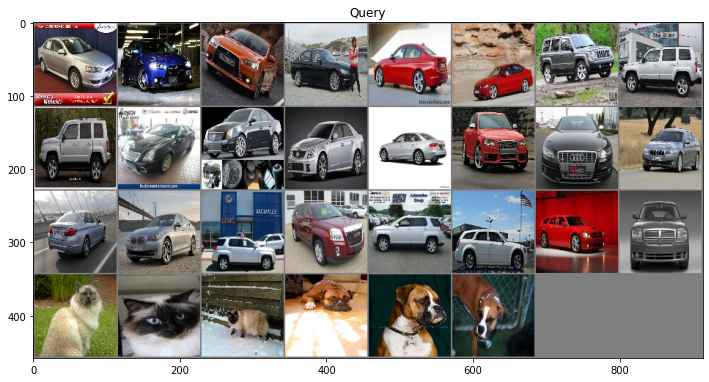

In [ ]:
plt.figure(figsize=(12, 12))

print(clases_query)
grid = torchvision.utils.make_grid(img_query)
imshow(grid, "Query")

# Dispositivo

Podrían pasarse una serie de datos a un dispositivo concreto, como CUDA:

In [ ]:
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datos_cuda = l2l.data.OnDeviceDataset(part_entrenamiento, device=dispositivo, transform=transforms)

Después de haber visto las anteriores funciones, ya se debería tener un nivel suficiente con el manejo de los datasets, como para poder resolver problemas de few-shot learning.

# Simulación de problema real

Dataset: cifar100.  
Objetivo: Se cargará el dataset de la base de datos de torchcvision, se crearán las particiones de entrenamiento y validación, y se pasará a formato de few-shot con sus respectivas transformaciones.

In [ ]:
transformaciones = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                   ])

# Se cargan los datasets
cifar100_train = torchvision.datasets.CIFAR100(root = "./cifar100", train = True, download=True)
cifar100_test = torchvision.datasets.CIFAR100(root = "./cifar100", train = False, transform = transformaciones, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar100/cifar-100-python.tar.gz to ./cifar100
Files already downloaded and verified


Se crea la siguiente clase para poder dividir los datos de train, en train y validación

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      sample = self.X[idx]
      if self.transform:
        sample = self.transform(sample)
      return sample, self.y[idx]

In [ ]:
len(cifar100_train.targets)

50000

Se dividen los datos en train y validación

In [ ]:
X_train, y_train = cifar100_train.data[:40000], cifar100_train.targets[:40000]
X_val, y_val = cifar100_train.data[40000:], cifar100_train.targets[40000:]

train = Dataset(X_train, y_train, transformaciones)
val = Dataset(X_val, y_val, transformaciones)

train_meta = l2l.data.MetaDataset(train)
val_meta = l2l.data.MetaDataset(val)

Se crea el metadataset de test

In [ ]:
test_set = l2l.data.MetaDataset(cifar100_test)

Parámetros del dataset

In [ ]:
n_ways = 10
k_shots = 10
tareas_entrenamiento = 10000
tareas_val = 1000

train

In [ ]:
transformaciones_metalearning = [
                    # Se dividen los datos de entrenamiento en n clases con k instancias cada una.
                    l2l.data.transforms.FusedNWaysKShots(train_meta, n=n_ways, k=k_shots),
                    # Se cargan los datos en base a los ajustes anteriores
                    l2l.data.transforms.LoadData(train_meta),
                    # Se remapean las etiquetas de 0 a len(unique(train_dataset.labels))
                    l2l.data.transforms.RemapLabels(train_meta),
                    # Se ordenan las instancias en función de su clase de forma que vaya de 0 a len(unique(train_dataset.labels))
                    l2l.data.transforms.ConsecutiveLabels(train_meta),
]

task_train = l2l.data.TaskDataset(train_meta, transformaciones_metalearning, num_tasks=tareas_entrenamiento)

validación

In [ ]:
transformaciones_metalearning = [
                    l2l.data.transforms.FusedNWaysKShots(val_meta, n=n_ways, k=k_shots),
                    l2l.data.transforms.LoadData(val_meta),
                    l2l.data.transforms.RemapLabels(val_meta),
                    l2l.data.transforms.ConsecutiveLabels(val_meta),
]

task_val = l2l.data.TaskDataset(val_meta, transformaciones_metalearning, num_tasks=tareas_val)

test

In [ ]:
transformaciones_metalearning = [
                    l2l.data.transforms.FusedNWaysKShots(test_set, n=n_ways, k=k_shots),
                    l2l.data.transforms.LoadData(test_set),
                    l2l.data.transforms.RemapLabels(test_set),
                    l2l.data.transforms.ConsecutiveLabels(test_set),
]

task_test = l2l.data.TaskDataset(test_set, transformaciones_metalearning, num_tasks=tareas_val)

Se visualizan los datos:

In [ ]:
import matplotlib.pyplot as plt
def imshow(img, title = ""):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

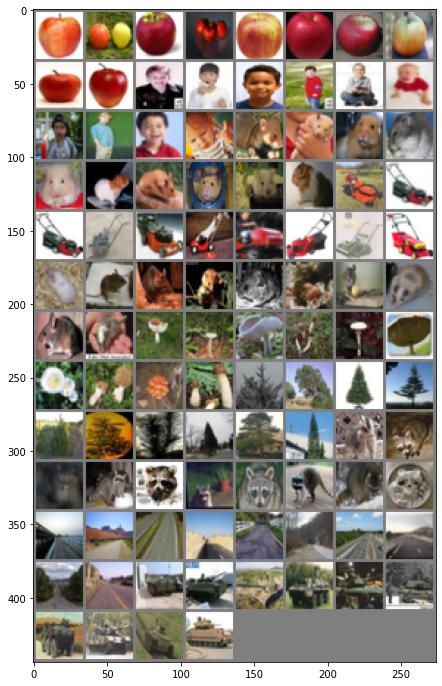

In [ ]:
X, y = task_train.sample()

plt.figure(figsize=(12, 12))
grid = torchvision.utils.make_grid(X)
imshow(grid)

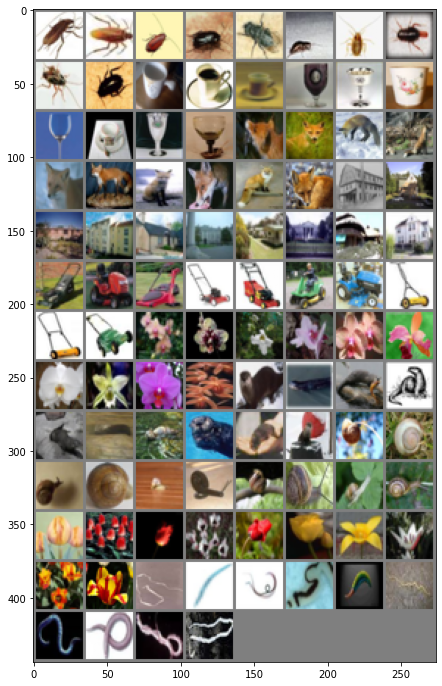

In [ ]:
X, y = task_val.sample()

plt.figure(figsize=(12, 12))
grid = torchvision.utils.make_grid(X)
imshow(grid)

In [ ]:
task_train.sample()[1]

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9])

In [ ]:
task_val.sample()[1]

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

Las dimensiones son:

In [ ]:
task_train.sample()[0].shape

torch.Size([100, 3, 32, 32])

10 clases x 10 muestras por cada clase, e imágenes de (3, 32, 32) cada una.

# Conclusión

Como puede observarse, learn2learn es una herramienta bastante completa, que incluye un gran abanico a la hora de trabajar con conjuntos de datos y adaptarlos de forma muy personalizable a problemas de few-shot learning. Con todo lo visto hasta ahora, ya se dispondría de recursos suficientes como para abarcar el manejo de datasets en un problema de few-shot learning.